<a href="https://colab.research.google.com/github/MoRebaie/Sequences-Time-Series-Prediction-in-Tensorflow/blob/master/Course_4_Week_4_Lesson_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 6s 787ms/step - loss: 73.2800 - mae: 73.6896
Epoch 2/100
8/8 [==============================] - 0s 57ms/step - loss: 72.6322 - mae: 72.9788
Epoch 3/100
8/8 [==============================] - 0s 59ms/step - loss: 71.4605 - mae: 71.8377
Epoch 4/100
8/8 [==============================] - 0s 59ms/step - loss: 70.0359 - mae: 70.4184
Epoch 5/100
8/8 [==============================] - 0s 59ms/step - loss: 68.2689 - mae: 68.7583
Epoch 6/100
8/8 [==============================] - 0s 60ms/step - loss: 66.4883 - mae: 66.8782
Epoch 7/100
8/8 [==============================] - 0s 59ms/step - loss: 64.2616 - mae: 64.7354
Epoch 8/100
8/8 [==============================] - 0s 60ms/step - loss: 62.0457 - mae: 62.3713
Epoch 9/100
8/8 [==============================] - 0s 59ms/step - loss: 59.3746 - mae: 59.7458
Epoch 10/100
8/8 [==============================] - 0s 59ms/step - loss: 56.3313 - mae: 56.8317
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 1s 77ms/step - loss: 14.8108 - mae: 15.0955
Epoch 88/100
8/8 [==============================] - 1s 73ms/step - loss: 17.2952 - mae: 17.5892
Epoch 89/100
8/8 [==============================] - 1s 68ms/step - loss: 27.2406 - mae: 28.5509
Epoch 90/100
8/8 [==============================] - 1s 69ms/step - loss: 23.4087 - mae: 24.2059
Epoch 91/100
8/8 [==============================] - 1s 69ms/step - loss: 17.5915 - mae: 17.9008
Epoch 92/100
8/8 [==============================] - 1s 67ms/step - loss: 12.7930 - mae: 12.9598
Epoch 93/100
8/8 [==============================] - 1s 69ms/step - loss: 16.2716 - mae: 16.9779
Epoch 94/100
8/8 [==============================] - 1s 67ms/step - loss: 15.1466 - mae: 15.5649
Epoch 95/100
8/8 [==============================] - 1s 66ms/step - loss: 13.0139 - mae: 14.1979
Epoch 96/100
8/8 [==============================] - 1s 68ms/step - loss: 17.6362 - mae: 18.0864
Epoch 97/100
8/8 [==============================] - 1

[1e-08, 0.0001, 0, 30]

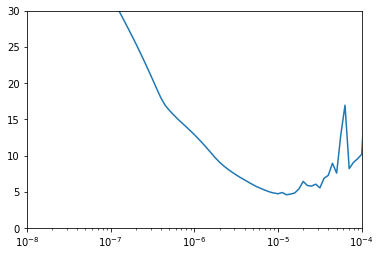

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 4s 126ms/step - loss: 21.5713 - mae: 22.3311
Epoch 2/500
31/31 [==============================] - 1s 27ms/step - loss: 8.2302 - mae: 8.7146
Epoch 3/500
31/31 [==============================] - 1s 27ms/step - loss: 6.6534 - mae: 7.1294
Epoch 4/500
31/31 [==============================] - 1s 27ms/step - loss: 6.5002 - mae: 6.9854
Epoch 5/500
31/31 [==============================] - 1s 26ms/step - loss: 5.9386 - mae: 6.4156
Epoch 6/500
31/31 [==============================] - 1s 26ms/step - loss: 5.5543 - mae: 6.0331
Epoch 7/500
31/31 [==============================] - 1s 30ms/step - loss: 5.4390 - mae: 5.9184
Epoch 8/500
31/31 [==============================] - 1s 31ms/step - loss: 5.3779 - mae: 5.8581
Epoch 9/500
31/31 [==============================] - 1s 28ms/step - loss: 5.2132 - mae: 5.6865
Epoch 10/500
31/31 [==============================] - 1s 29ms/step - loss: 5.2147 - mae: 5.6892
Epoch 11/500
31/31 [==========================

31/31 [==============================] - 1s 46ms/step - loss: 4.3820 - mae: 4.8563
Epoch 87/500
31/31 [==============================] - 1s 43ms/step - loss: 4.2660 - mae: 4.7405
Epoch 88/500
31/31 [==============================] - 1s 47ms/step - loss: 4.3056 - mae: 4.7814
Epoch 89/500
31/31 [==============================] - 1s 41ms/step - loss: 4.2360 - mae: 4.7047
Epoch 90/500
31/31 [==============================] - 1s 40ms/step - loss: 4.2206 - mae: 4.6978
Epoch 91/500
31/31 [==============================] - 1s 43ms/step - loss: 4.2354 - mae: 4.7101
Epoch 92/500
31/31 [==============================] - 1s 44ms/step - loss: 4.2544 - mae: 4.7266
Epoch 93/500
31/31 [==============================] - 1s 40ms/step - loss: 4.2272 - mae: 4.7036
Epoch 94/500
31/31 [==============================] - 1s 37ms/step - loss: 4.2146 - mae: 4.6930
Epoch 95/500
31/31 [==============================] - 1s 37ms/step - loss: 4.3025 - mae: 4.7765
Epoch 96/500
31/31 [==============================] -

31/31 [==============================] - 1s 35ms/step - loss: 4.1151 - mae: 4.5874
Epoch 171/500
31/31 [==============================] - 1s 34ms/step - loss: 4.2339 - mae: 4.7130
Epoch 172/500
31/31 [==============================] - 1s 34ms/step - loss: 4.1303 - mae: 4.6005
Epoch 173/500
31/31 [==============================] - 1s 33ms/step - loss: 4.1611 - mae: 4.6370
Epoch 174/500
31/31 [==============================] - 1s 33ms/step - loss: 4.1042 - mae: 4.5785
Epoch 175/500
31/31 [==============================] - 1s 33ms/step - loss: 4.1088 - mae: 4.5814
Epoch 176/500
31/31 [==============================] - 1s 36ms/step - loss: 4.1157 - mae: 4.5922
Epoch 177/500
31/31 [==============================] - 1s 33ms/step - loss: 4.1321 - mae: 4.6065
Epoch 178/500
31/31 [==============================] - 1s 33ms/step - loss: 4.1152 - mae: 4.5924
Epoch 179/500
31/31 [==============================] - 1s 34ms/step - loss: 4.1021 - mae: 4.5779
Epoch 180/500
31/31 [=======================

31/31 [==============================] - 1s 36ms/step - loss: 4.0424 - mae: 4.5160
Epoch 255/500
31/31 [==============================] - 1s 38ms/step - loss: 4.0382 - mae: 4.5100
Epoch 256/500
31/31 [==============================] - 1s 35ms/step - loss: 4.1303 - mae: 4.6026
Epoch 257/500
31/31 [==============================] - 1s 34ms/step - loss: 4.0989 - mae: 4.5692
Epoch 258/500
31/31 [==============================] - 1s 35ms/step - loss: 4.0891 - mae: 4.5643
Epoch 259/500
31/31 [==============================] - 1s 35ms/step - loss: 4.0555 - mae: 4.5310
Epoch 260/500
31/31 [==============================] - 1s 39ms/step - loss: 4.0609 - mae: 4.5327
Epoch 261/500
31/31 [==============================] - 1s 35ms/step - loss: 4.1134 - mae: 4.5921
Epoch 262/500
31/31 [==============================] - 1s 36ms/step - loss: 4.1694 - mae: 4.6399
Epoch 263/500
31/31 [==============================] - 1s 34ms/step - loss: 4.0970 - mae: 4.5729
Epoch 264/500
31/31 [=======================

31/31 [==============================] - 1s 33ms/step - loss: 4.0150 - mae: 4.4894
Epoch 339/500
31/31 [==============================] - 1s 32ms/step - loss: 3.9966 - mae: 4.4683
Epoch 340/500
31/31 [==============================] - 1s 33ms/step - loss: 3.9764 - mae: 4.4487
Epoch 341/500
31/31 [==============================] - 1s 34ms/step - loss: 4.0517 - mae: 4.5293
Epoch 342/500
31/31 [==============================] - 1s 35ms/step - loss: 4.1154 - mae: 4.5849
Epoch 343/500
31/31 [==============================] - 1s 42ms/step - loss: 4.0126 - mae: 4.4864
Epoch 344/500
31/31 [==============================] - 1s 38ms/step - loss: 4.0161 - mae: 4.4904
Epoch 345/500
31/31 [==============================] - 1s 33ms/step - loss: 4.0448 - mae: 4.5161
Epoch 346/500
31/31 [==============================] - 1s 34ms/step - loss: 4.0233 - mae: 4.4975
Epoch 347/500
31/31 [==============================] - 1s 35ms/step - loss: 3.9756 - mae: 4.4481
Epoch 348/500
31/31 [=======================

31/31 [==============================] - 1s 33ms/step - loss: 3.9290 - mae: 4.4026
Epoch 423/500
31/31 [==============================] - 1s 38ms/step - loss: 3.9478 - mae: 4.4215
Epoch 424/500
31/31 [==============================] - 1s 34ms/step - loss: 3.9508 - mae: 4.4264
Epoch 425/500
31/31 [==============================] - 1s 32ms/step - loss: 3.9478 - mae: 4.4229
Epoch 426/500
31/31 [==============================] - 1s 32ms/step - loss: 3.9692 - mae: 4.4396
Epoch 427/500
31/31 [==============================] - 1s 31ms/step - loss: 3.9569 - mae: 4.4270
Epoch 428/500
31/31 [==============================] - 1s 32ms/step - loss: 3.9857 - mae: 4.4542
Epoch 429/500
31/31 [==============================] - 1s 32ms/step - loss: 3.9266 - mae: 4.3960
Epoch 430/500
31/31 [==============================] - 1s 33ms/step - loss: 3.9322 - mae: 4.4052
Epoch 431/500
31/31 [==============================] - 1s 32ms/step - loss: 4.0002 - mae: 4.4703
Epoch 432/500
31/31 [=======================

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

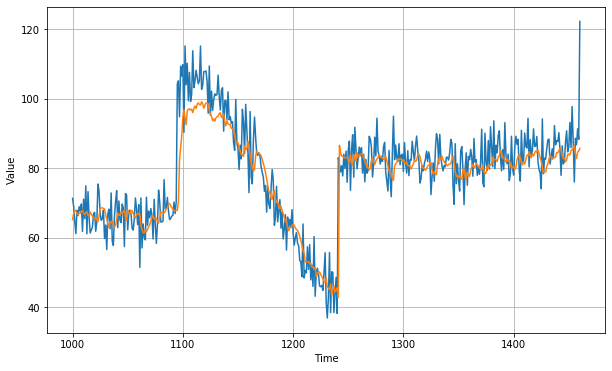

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.0795307

<Figure size 432x288 with 0 Axes>

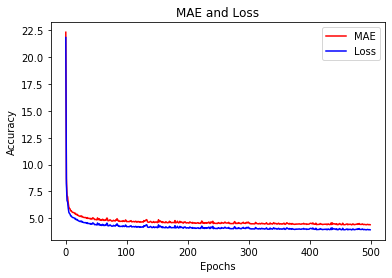

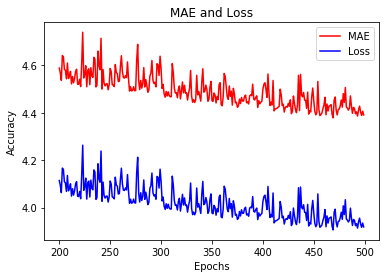

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()